1. Генерація за допомогою рекурентної мережі

In [ ]:
import keras
from keras import layers

import numpy as np
import random
import io

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = 'drive/MyDrive/ml_files/Lys_mykyta.txt'
with io.open(path, encoding="utf-8") as f:
    text = f.read().lower()
text = text.replace("\n", " ")  # We remove newlines chars for nicer display
print("Corpus length:", len(text))

chars = sorted(list(set(text)))
print("Total chars:", len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i : i + maxlen])
    next_chars.append(text[i + maxlen])
print("Number of sequences:", len(sentences))

x = np.zeros((len(sentences), maxlen, len(chars)), dtype="bool")
y = np.zeros((len(sentences), len(chars)), dtype="bool")
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Corpus length: 86526
Total chars: 49
Number of sequences: 28829


In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=(maxlen, len(chars))),
        layers.LSTM(128),
        layers.Dense(len(chars), activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)

In [ ]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:
epochs = 50
batch_size = 128

for epoch in range(epochs):
    model.fit(x, y, batch_size=batch_size, epochs=1)
    print()
    print("Generating text after epoch: %d" % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print("...Diversity:", diversity)

        generated = ""
        sentence = text[start_index : start_index + maxlen]
        print('...Generating with seed: "' + sentence + '"')

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.0
            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]
            sentence = sentence[1:] + next_char
            generated += next_char

        print("...Generated: ", generated)
        print("-")

226/226 [==============================] - 30s 121ms/step - loss: 2.7635

Generating text after epoch: 0
...Diversity: 0.2
...Generating with seed: "він примостився, мав царицю за куму?  вс"
...Generated:  здрити, таж тобне заметь, тав тадне, тобровся, таб таз зажеть!  таж тав таж тав завстий таж тав тав тав тоб видна, тав порити, та там тав тар застив тай барне, тай вся потать!  таж тав затить, таж вснена, таж зажеш, поговста, таж тавсь, тобуть, таж там модне затав, та затить!  тасть, таж тав тодне повстить, таз побровсь, тобум тав всять!  тобромить, тоб тав порід таж портрав, та дідня, тавсть, тав
-
...Diversity: 0.5
...Generating with seed: "він примостився, мав царицю за куму?  вс"
...Generated:  зрив.  пожіли порідна, вість! та нажеть! – ній домитий повстра, таж мозмисть? нубедне, басть, туй підня, ту тав тай побіш,  – зпідуть!  мознух тобать!  тита, тородев додражь, та бавсть!  зужемить:  подіт помозає:  лизнав.  всзнав!:  тоснять, пордвсти помне, «абред таж тамі, тостаскав зарод

In [ ]:
from transformers import pipeline

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
classifier = pipeline('sentiment-analysis')
classifier(['Wow, I had a wonderful time with you!', 'It is disgusting'])

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.9998778104782104},
 {'label': 'NEGATIVE', 'score': 0.9991686344146729}]

In [ ]:
classifier = pipeline("zero-shot-classification")
classifier(
    "it has 200 horsepower under the hood and accelerates to 100 in 5 seconds",
    candidate_labels=["cars", "politics", "business"],
)

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

{'sequence': 'it has 200 horsepower under the hood and accelerates to 100 in 5 seconds',
 'labels': ['cars', 'business', 'politics'],
 'scores': [0.892927885055542, 0.09474287182092667, 0.012329252436757088]}

In [ ]:
generator = pipeline("text-generation", model="benjamin/gpt2-large-wechsel-ukrainian")
generator("Привіт, давай я розкажу тобі про")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Привіт, давай я розкажу тобі про це. Справа в тому, що ми живемо в час, коли, напевно, чи не кожен із вас знає про Вікіпедію. Це глобальна енциклопедія, яка має майже 90-відсотковий доступ до багатьох статей'}]

In [ ]:
unmasker = pipeline("fill-mask")
unmasker("My favorite color is <mask>", top_k=5)

No model was supplied, defaulted to distilroberta-base and revision ec58a5b (https://huggingface.co/distilroberta-base).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'score': 0.13937489688396454,
  'token': 14327,
  'token_str': ' purple',
  'sequence': 'My favorite color is purple'},
 {'score': 0.07786301523447037,
  'token': 6907,
  'token_str': ' pink',
  'sequence': 'My favorite color is pink'},
 {'score': 0.0728292465209961,
  'token': 2440,
  'token_str': ' blue',
  'sequence': 'My favorite color is blue'},
 {'score': 0.06352388858795166,
  'token': 8978,
  'token_str': ' orange',
  'sequence': 'My favorite color is orange'},
 {'score': 0.051205139607191086,
  'token': 909,
  'token_str': ' black',
  'sequence': 'My favorite color is black'}]

In [ ]:
ner = pipeline("ner", grouped_entities=True)
ner("Peter was born in Ukraine and he made carrer in Google")

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-p

[{'entity_group': 'PER',
  'score': 0.99940014,
  'word': 'Peter',
  'start': 0,
  'end': 5},
 {'entity_group': 'LOC',
  'score': 0.9997241,
  'word': 'Ukraine',
  'start': 18,
  'end': 25},
 {'entity_group': 'ORG',
  'score': 0.9866961,
  'word': 'Google',
  'start': 48,
  'end': 54}]

In [ ]:
question_answerer = pipeline("question-answering")
question_answerer(
    question="How many kids do I have?",
    context="I have a son and a daughter",
)

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


{'score': 0.6031742691993713,
 'start': 7,
 'end': 27,
 'answer': 'a son and a daughter'}

3 Style transfer

In [20]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import numpy as np
import tensorflow as tf
from keras.applications import vgg19

base_image_path = keras.utils.get_file("as.jpg", "https://i.imgur.com/U1FG4Vf.jpeg")
style_reference_image_path = keras.utils.get_file(
    "style.jpg", "https://i.imgur.com/pYwq5tH.jpg"
)
result_prefix = "animal_generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = keras.utils.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

716602/716602 [==============================] - 0s 0us/step


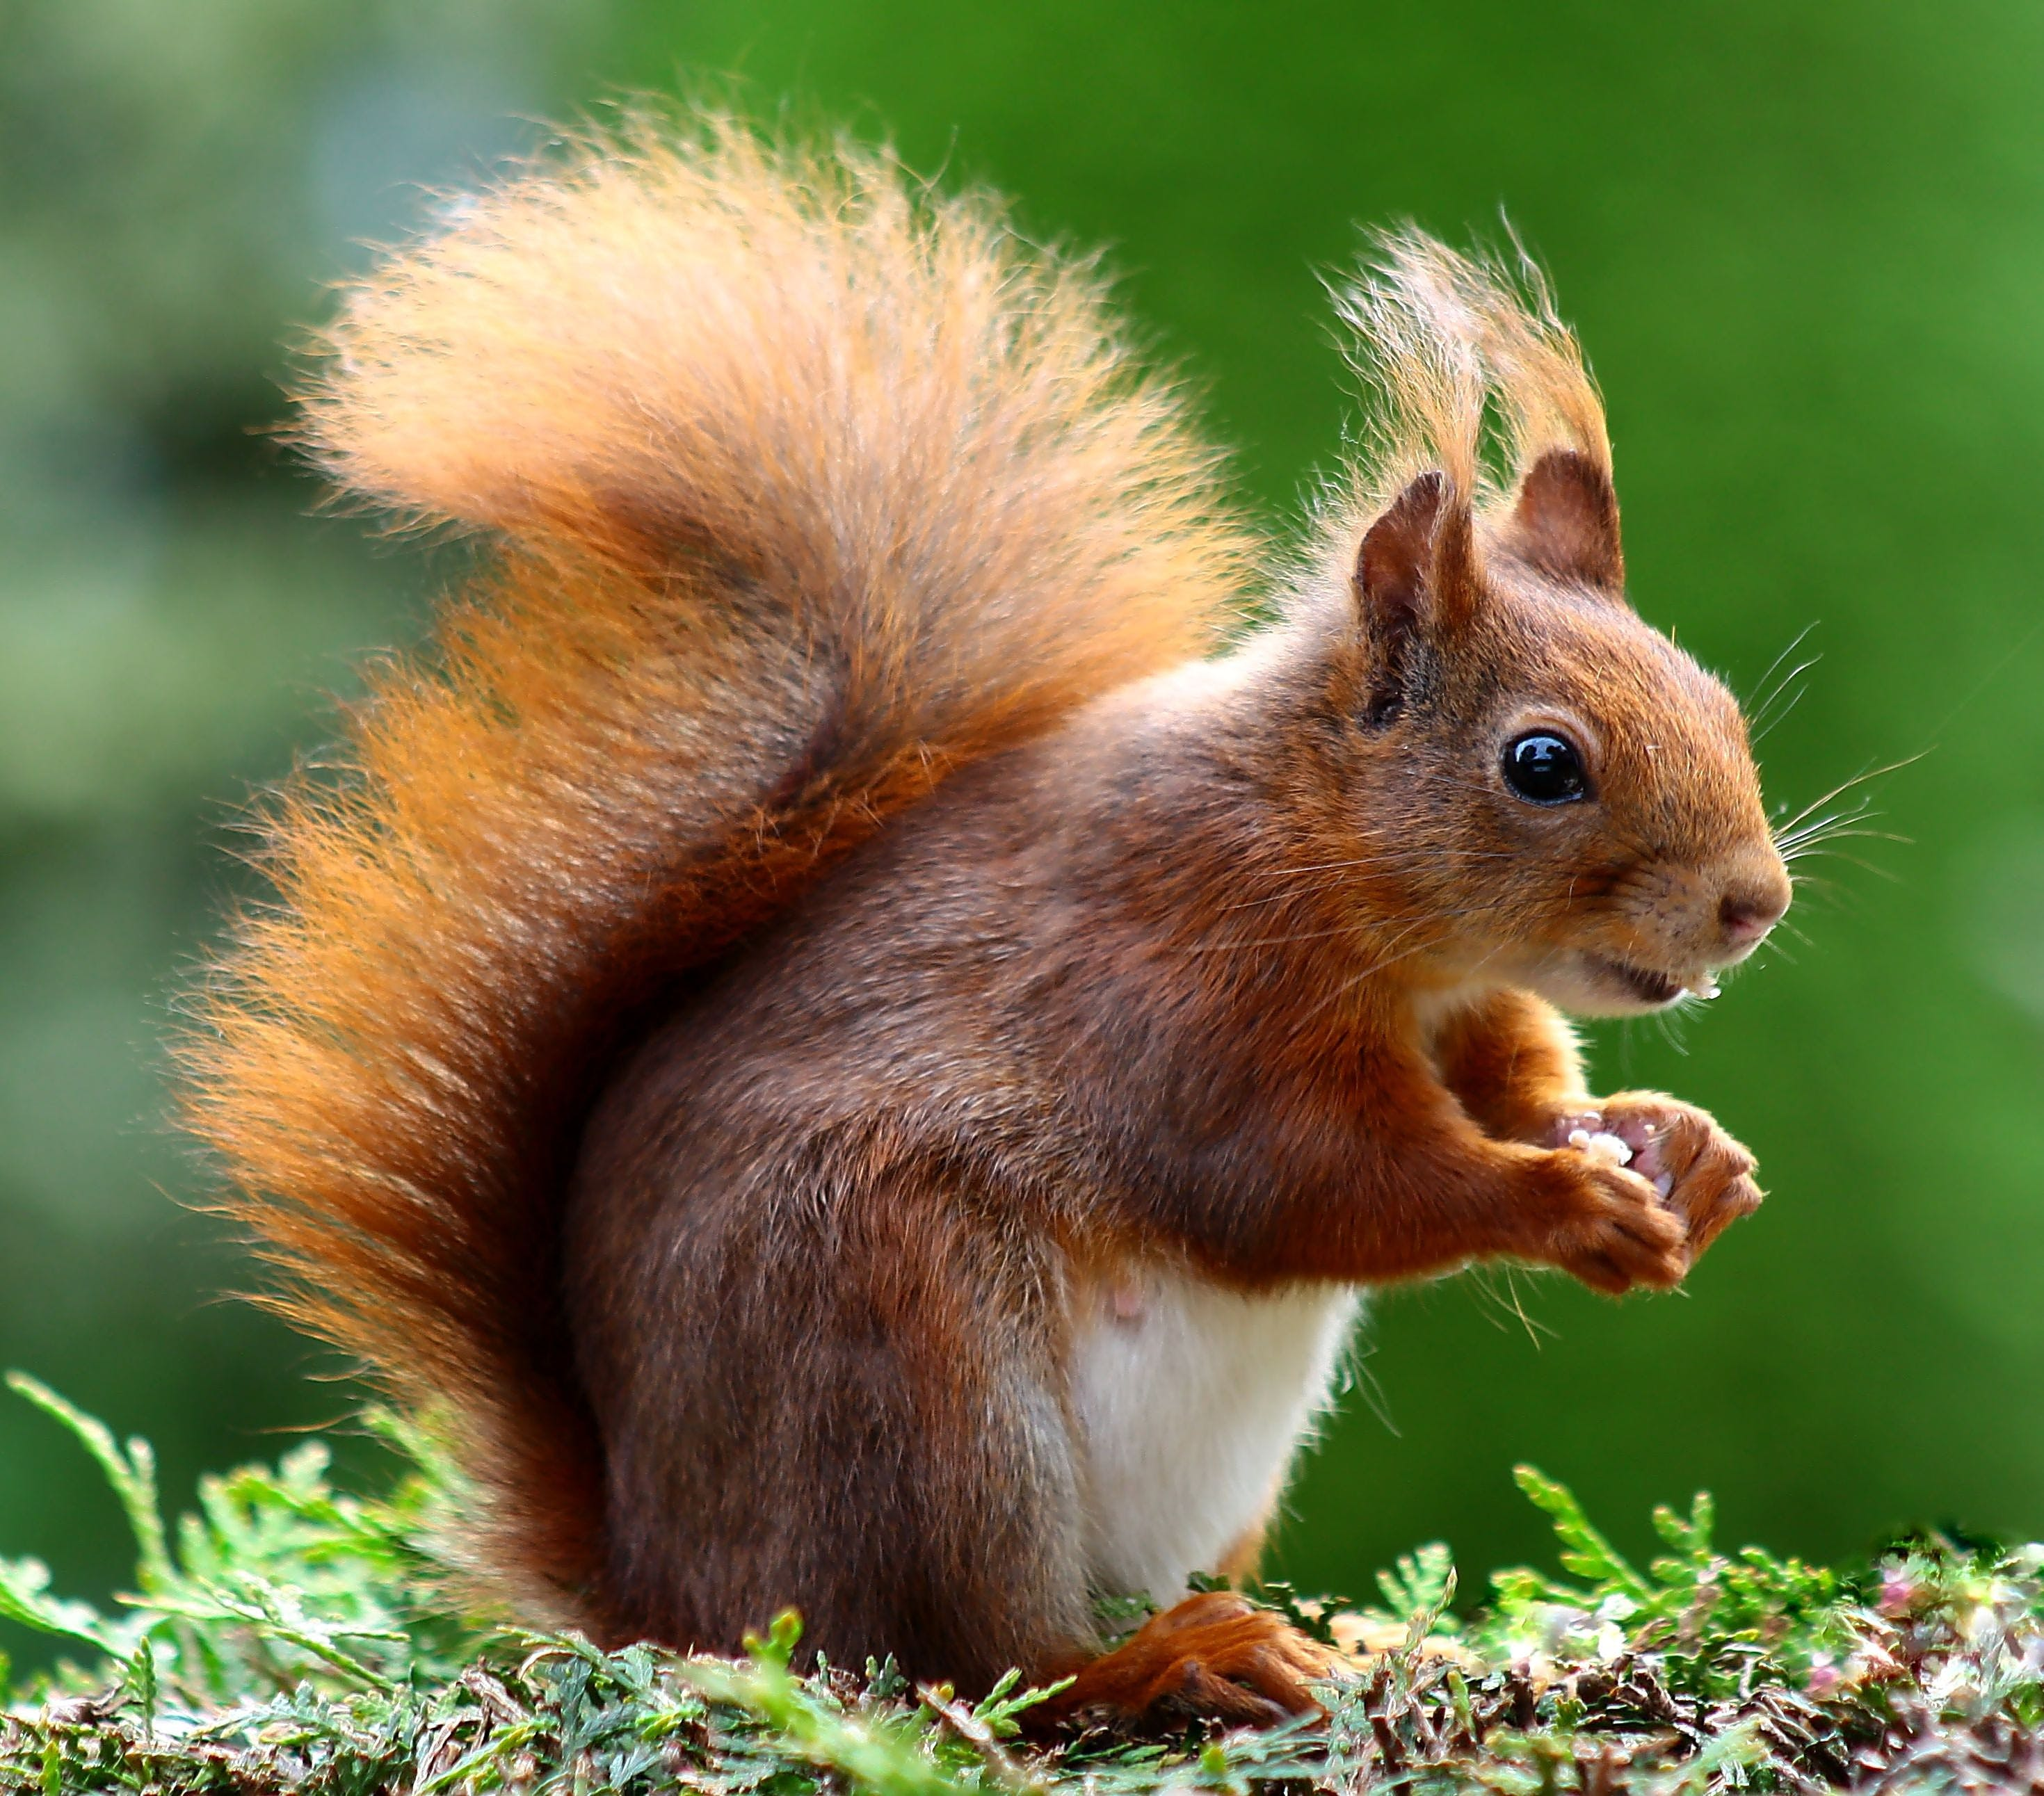

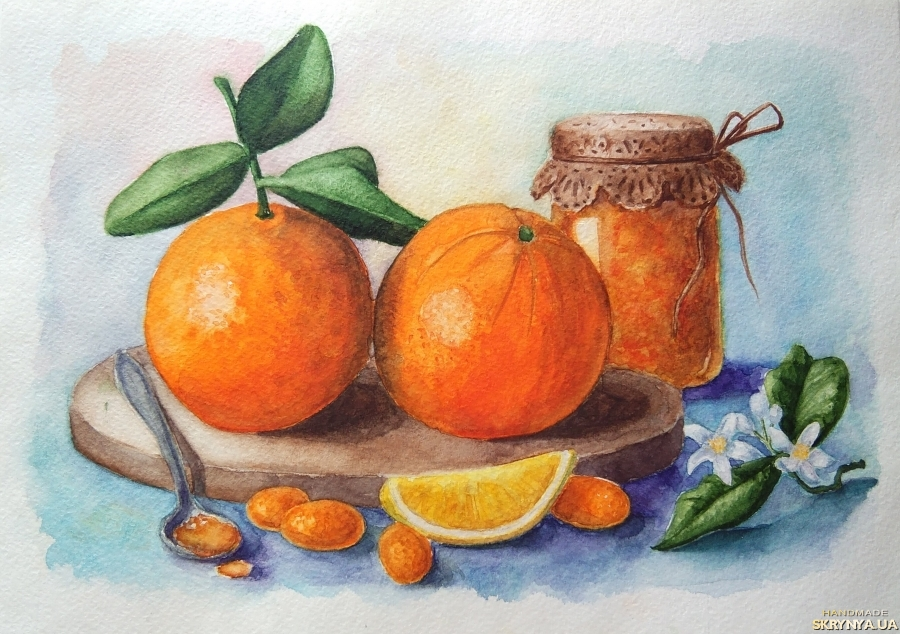

In [21]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))

In [22]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.utils.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [24]:
# The gram matrix of an image tensor (feature-wise outer product)


def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [25]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 [==============================] - 1s 0us/step


In [26]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [27]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads


In [28]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)§

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 100
for i in range(1, iterations + 1):
    print(i)
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.utils.save_img(fname, img)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
Iteration 100: loss=2263.48


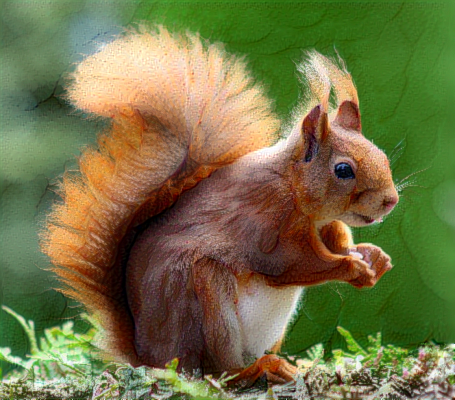

In [29]:
display(Image(result_prefix + "_at_iteration_100.png"))